In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
print("Ïäù=3")

Ïäù=3


In [2]:
# Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî© Î†àÏù¥Ïñ¥
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # Í∞ÅÎèÑ Î∞∞Ïó¥ ÏÉùÏÑ±
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # Î∞∞Ïó¥Ïùò ÏßùÏàò Ïù∏Îç±Ïä§ÏóêÎäî sin Ìï®Ïàò Ï†ÅÏö©
        sines = tf.math.sin(angle_rads[:, 0::2])
        # Î∞∞Ïó¥Ïùò ÌôÄÏàò Ïù∏Îç±Ïä§ÏóêÎäî cosine Ìï®Ïàò Ï†ÅÏö©
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sinÍ≥º cosineÏù¥ ÍµêÏ∞®ÎêòÎèÑÎ°ù Ïû¨Î∞∞Ïó¥
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("Ïäù=3")

Ïäù=3


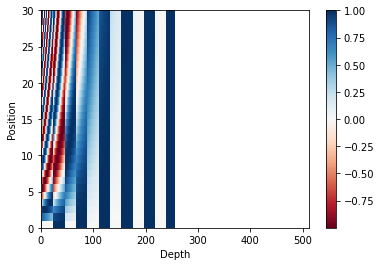

In [3]:
# sample_pos_encoding = PositionalEncoding(50, 128)
sample_pos_encoding = PositionalEncoding(30, 256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [4]:
# Ïä§ÏºÄÏùºÎìú Îã∑ ÌîÑÎ°úÎçïÌä∏ Ïñ¥ÌÖêÏÖò Ìï®Ïàò
def scaled_dot_product_attention(query, key, value, mask):
    # Ïñ¥ÌÖêÏÖò Í∞ÄÏ§ëÏπòÎäî QÏôÄ KÏùò Îã∑ ÌîÑÎ°úÎçïÌä∏
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # Í∞ÄÏ§ëÏπòÎ•º Ï†ïÍ∑úÌôî
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # Ìå®Îî©Ïóê ÎßàÏä§ÌÅ¨ Ï∂îÍ∞Ä
    if mask is not None:
        logits += (mask * -1e9)

    # softmaxÏ†ÅÏö©
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # ÏµúÏ¢Ö Ïñ¥ÌÖêÏÖòÏùÄ Í∞ÄÏ§ëÏπòÏôÄ VÏùò Îã∑ ÌîÑÎ°úÎçïÌä∏
    output = tf.matmul(attention_weights, value)
    return output

print("Ïäù=3")

Ïäù=3


### 15-6 Attention

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, VÏóê Í∞ÅÍ∞Å DenseÎ•º Ï†ÅÏö©Ìï©ÎãàÎã§
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Î≥ëÎ†¨ Ïó∞ÏÇ∞ÏùÑ ÏúÑÌïú Î®∏Î¶¨Î•º Ïó¨Îü¨ Í∞ú ÎßåÎì≠ÎãàÎã§
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # Ïä§ÏºÄÏùºÎìú Îã∑ ÌîÑÎ°úÎçïÌä∏ Ïñ¥ÌÖêÏÖò Ìï®Ïàò
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # Ïñ¥ÌÖêÏÖò Ïó∞ÏÇ∞ ÌõÑÏóê Í∞Å Í≤∞Í≥ºÎ•º Îã§Ïãú Ïó∞Í≤∞(concatenate)Ìï©ÎãàÎã§
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # ÏµúÏ¢Ö Í≤∞Í≥ºÏóêÎèÑ DenseÎ•º Ìïú Î≤à Îçî Ï†ÅÏö©Ìï©ÎãàÎã§
        outputs = self.dense(concat_attention)

        return outputs

print("Ïäù=3")

Ïäù=3


### 15-7 Masking

In [6]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]
print("Ïäù=3")

Ïäù=3


In [7]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [8]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

print("Ïäù=3")

Ïäù=3


In [9]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [10]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 15-8 Encoder

In [11]:
# Ïù∏ÏΩîÎçî ÌïòÎÇòÏùò Î†àÏù¥Ïñ¥Î•º Ìï®ÏàòÎ°ú Íµ¨ÌòÑ.
# Ïù¥ ÌïòÎÇòÏùò Î†àÏù¥Ïñ¥ ÏïàÏóêÎäî Îëê Í∞úÏùò ÏÑúÎ∏å Î†àÏù¥Ïñ¥Í∞Ä Ï°¥Ïû¨Ìï©ÎãàÎã§.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # Ìå®Îî© ÎßàÏä§ÌÅ¨ ÏÇ¨Ïö©
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # Ï≤´ Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò ÏàòÌñâ (ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # Ïñ¥ÌÖêÏÖòÏùò Í≤∞Í≥ºÎäî DropoutÍ≥º Layer NormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # Îëê Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : 2Í∞úÏùò ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µ
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µÏùò Í≤∞Í≥ºÎäî DropoutÍ≥º LayerNormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

print("Ïäù=3")

Ïäù=3


In [12]:
# Ïù∏ÏΩîÎçî Ï∏µ ÏåìÍ∏∞, 
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # Ìå®Îî© ÎßàÏä§ÌÅ¨ ÏÇ¨Ïö©
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    
    # ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    

    # Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî©
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    
    # num_layersÎßåÌÅº ÏåìÏïÑÏò¨Î¶∞ Ïù∏ÏΩîÎçîÏùò Ï∏µ, 
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])
        

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

print("Ïäù=3")

Ïäù=3


### 15-9 Decoder

Layers of Decoder: 
1. Self Attention
2. Encoder-Decoder 
3. Feed Forward Neural Network
4. Encoder-Decoder Attention




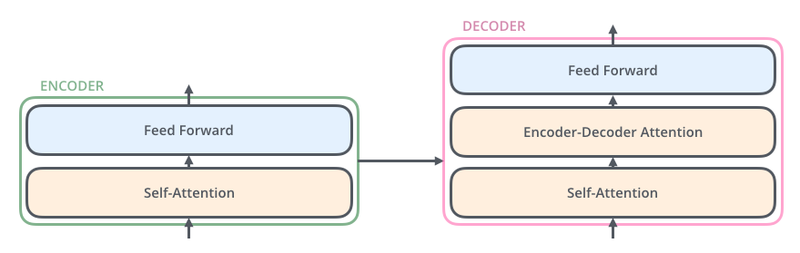

# 

Unlike Attention, Encoder-Decoder utilize Query as a vector for Decoder input and Key, Value as an Encoder input. 

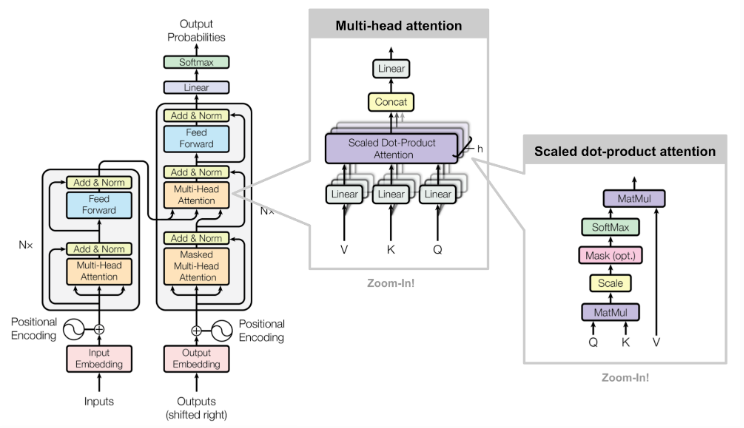

In [13]:
# ÎîîÏΩîÎçî ÌïòÎÇòÏùò Î†àÏù¥Ïñ¥Î•º Ìï®ÏàòÎ°ú Íµ¨ÌòÑ.
# Ïù¥ ÌïòÎÇòÏùò Î†àÏù¥Ïñ¥ ÏïàÏóêÎäî ÏÑ∏ Í∞úÏùò ÏÑúÎ∏å Î†àÏù¥Ïñ¥Í∞Ä Ï°¥Ïû¨Ìï©ÎãàÎã§.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # Ï≤´ Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò ÏàòÌñâ (ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖòÏùò Í≤∞Í≥ºÎäî LayerNormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # Îëê Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : ÎßàÏä§ÌÅ¨Îìú Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò ÏàòÌñâ (Ïù∏ÏΩîÎçî-ÎîîÏΩîÎçî Ïñ¥ÌÖêÏÖò)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # ÎßàÏä§ÌÅ¨Îìú Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖòÏùò Í≤∞Í≥ºÎäî
    # DropoutÍ≥º LayerNormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # ÏÑ∏ Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : 2Í∞úÏùò ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µ
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µÏùò Í≤∞Í≥ºÎäî DropoutÍ≥º LayerNormalization ÏàòÌñâ
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("Ïäù=3")

Ïäù=3


In [14]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # Ìå®Îî© ÎßàÏä§ÌÅ¨
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî©
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # DropoutÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

print("Ïäù=3")

Ïäù=3


### 15-10 Chatbot

In [15]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')
print("Ïäù=3")

Ïäù=3


In [16]:
# ÏÇ¨Ïö©Ìï† ÏÉòÌîåÏùò ÏµúÎåÄ Í∞úÏàò
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [17]:
# Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò
def preprocess_sentence(sentence):
    # ÏûÖÎ†•Î∞õÏùÄ sentenceÎ•º ÏÜåÎ¨∏ÏûêÎ°ú Î≥ÄÍ≤ΩÌïòÍ≥† ÏñëÏ™Ω Í≥µÎ∞±ÏùÑ Ï†úÍ±∞
    sentence = sentence.lower().strip()

    # Îã®Ïñ¥ÏôÄ Íµ¨ÎëêÏ†ê(punctuation) ÏÇ¨Ïù¥Ïùò Í±∞Î¶¨Î•º ÎßåÎì≠ÎãàÎã§.
    # ÏòàÎ•º Îì§Ïñ¥ÏÑú "I am a student." => "I am a student ."ÏôÄ Í∞ôÏù¥
    # studentÏôÄ Ïò®Ï†ê ÏÇ¨Ïù¥Ïóê Í±∞Î¶¨Î•º ÎßåÎì≠ÎãàÎã§.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, ".", "?", "!", ",")Î•º Ï†úÏô∏Ìïú Î™®Îì† Î¨∏ÏûêÎ•º Í≥µÎ∞±Ïù∏ ' 'Î°ú ÎåÄÏ≤¥Ìï©ÎãàÎã§.
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

print("Ïäù=3")

Ïäù=3


In [18]:
# ÏßàÎ¨∏Í≥º ÎãµÎ≥ÄÏùò ÏåçÏù∏ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Íµ¨ÏÑ±ÌïòÍ∏∞ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ìï®Ïàò
def load_conversations():
    id2line = {}
    with open(path_to_movie_lines, errors='ignore') as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        id2line[parts[0]] = parts[4]

    inputs, outputs = [], []
    with open(path_to_movie_conversations, 'r') as file:
        lines = file.readlines()

    for line in lines:
        parts = line.replace('\n', '').split(' +++$+++ ')
        conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

        for i in range(len(conversation) - 1):
            # Ï†ÑÏ≤òÎ¶¨ Ìï®ÏàòÎ•º ÏßàÎ¨∏Ïóê Ìï¥ÎãπÎêòÎäî inputsÏôÄ ÎãµÎ≥ÄÏóê Ìï¥ÎãπÎêòÎäî outputsÏóê Ï†ÅÏö©.
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

            if len(inputs) >= MAX_SAMPLES:
                return inputs, outputs
    
    return inputs, outputs

print("Ïäù=3")

Ïäù=3


In [19]:
# Îç∞Ïù¥ÌÑ∞Î•º Î°úÎìúÌïòÍ≥† Ï†ÑÏ≤òÎ¶¨ÌïòÏó¨ ÏßàÎ¨∏ÏùÑ questions, ÎãµÎ≥ÄÏùÑ answersÏóê Ï†ÄÏû•Ìï©ÎãàÎã§.
questions, answers = load_conversations()
print('Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò :', len(questions))
print('Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò :', len(answers))

Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò : 50000
Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò : 50000


In [20]:
print('Ï†ÑÏ≤òÎ¶¨ ÌõÑÏùò 22Î≤àÏß∏ ÏßàÎ¨∏ ÏÉòÌîå: {}'.format(questions[21]))
print('Ï†ÑÏ≤òÎ¶¨ ÌõÑÏùò 22Î≤àÏß∏ ÎãµÎ≥Ä ÏÉòÌîå: {}'.format(answers[21]))

Ï†ÑÏ≤òÎ¶¨ ÌõÑÏùò 22Î≤àÏß∏ ÏßàÎ¨∏ ÏÉòÌîå: she s not a . . .
Ï†ÑÏ≤òÎ¶¨ ÌõÑÏùò 22Î≤àÏß∏ ÎãµÎ≥Ä ÏÉòÌîå: lesbian ? no . i found a picture of jared leto in one of her drawers , so i m pretty sure she s not harboring same sex tendencies .


### 15-11 Î≥ëÎ†¨Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

In [21]:
import tensorflow_datasets as tfds
print("ÏÇ¥Ïßù Ïò§Îûò Í±∏Î¶¥ Ïàò ÏûàÏñ¥Ïöî. Ïä§Ìä∏Î†àÏπ≠ Ìïú Î≤à Ìï¥Î≥ºÍπåÏöî? üëê")

# ÏßàÎ¨∏Í≥º ÎãµÎ≥Ä Îç∞Ïù¥ÌÑ∞ÏÖãÏóê ÎåÄÌï¥ÏÑú Vocabulary ÏÉùÏÑ±
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("Ïäù=3 ")

ÏÇ¥Ïßù Ïò§Îûò Í±∏Î¶¥ Ïàò ÏûàÏñ¥Ïöî. Ïä§Ìä∏Î†àÏπ≠ Ìïú Î≤à Ìï¥Î≥ºÍπåÏöî? üëê
Ïäù=3 


In [22]:
# ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞Ïóê Í≥†Ïú†Ìïú Ï†ïÏàòÎ•º Î∂ÄÏó¨Ìï©ÎãàÎã§.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("Ïäù=3")

Ïäù=3


In [23]:
print('START_TOKENÏùò Î≤àÌò∏ :' ,[tokenizer.vocab_size])
print('END_TOKENÏùò Î≤àÌò∏ :' ,[tokenizer.vocab_size + 1])

START_TOKENÏùò Î≤àÌò∏ : [8331]
END_TOKENÏùò Î≤àÌò∏ : [8332]


In [24]:
# ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ Í≥†Î†§ÌïòÏó¨ +2Î•º ÌïòÏó¨ Îã®Ïñ¥Ïû•Ïùò ÌÅ¨Í∏∞Î•º ÏÇ∞Ï†ïÌï©ÎãàÎã§.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8333


In [25]:
# ÏûÑÏùòÏùò 22Î≤àÏß∏ ÏÉòÌîåÏóê ÎåÄÌï¥ÏÑú Ï†ïÏàò Ïù∏ÏΩîÎî© ÏûëÏóÖÏùÑ ÏàòÌñâ.
# Í∞Å ÌÜ†ÌÅ∞ÏùÑ Í≥†Ïú†Ìïú Ï†ïÏàòÎ°ú Î≥ÄÌôò
print('Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò 21Î≤àÏß∏ ÏßàÎ¨∏ ÏÉòÌîå: {}'.format(tokenizer.encode(questions[21])))
print('Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò 21Î≤àÏß∏ ÎãµÎ≥Ä ÏÉòÌîå: {}'.format(tokenizer.encode(answers[21])))

Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò 21Î≤àÏß∏ ÏßàÎ¨∏ ÏÉòÌîå: [60, 8, 37, 8172, 49]
Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò 21Î≤àÏß∏ ÎãµÎ≥Ä ÏÉòÌîå: [7824, 1223, 19, 61, 2, 4, 336, 10, 1595, 14, 1104, 698, 3263, 263, 16, 71, 14, 107, 2133, 900, 3, 59, 4, 23, 355, 204, 60, 8, 37, 885, 2289, 8107, 344, 1001, 5179, 4214, 342, 1]


In [26]:
# ÏÉòÌîåÏùò ÏµúÎåÄ ÌóàÏö© Í∏∏Ïù¥ ÎòêÎäî Ìå®Îî© ÌõÑÏùò ÏµúÏ¢Ö Í∏∏Ïù¥
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [27]:
# Ï†ïÏàò Ïù∏ÏΩîÎî©, ÏµúÎåÄ Í∏∏Ïù¥Î•º Ï¥àÍ≥ºÌïòÎäî ÏÉòÌîå Ï†úÍ±∞, Ìå®Îî©
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # Ï†ïÏàò Ïù∏ÏΩîÎî© Í≥ºÏ†ïÏóêÏÑú ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ Ï∂îÍ∞Ä
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # ÏµúÎåÄ Í∏∏Ïù¥ 40 Ïù¥ÌïòÏù∏ Í≤ΩÏö∞ÏóêÎßå Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú ÌóàÏö©
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # ÏµúÎåÄ Í∏∏Ïù¥ 40ÏúºÎ°ú Î™®Îì† Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Ìå®Îî©
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs
print("Ïäù=3")

Ïäù=3


In [28]:
questions, answers = tokenize_and_filter(questions, answers)
print('Îã®Ïñ¥Ïû•Ïùò ÌÅ¨Í∏∞ :',(VOCAB_SIZE))
print('ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÏßàÎ¨∏ ÏÉòÌîå Í∞úÏàò: {}'.format(len(questions)))
print('ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÎãµÎ≥Ä ÏÉòÌîå Í∞úÏàò: {}'.format(len(answers)))

Îã®Ïñ¥Ïû•Ïùò ÌÅ¨Í∏∞ : 8333
ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÏßàÎ¨∏ ÏÉòÌîå Í∞úÏàò: 44095
ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÎãµÎ≥Ä ÏÉòÌîå Í∞úÏàò: 44095


In [29]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# ÎîîÏΩîÎçîÎäî Ïù¥Ï†ÑÏùò targetÏùÑ Îã§ÏùåÏùò inputÏúºÎ°ú ÏÇ¨Ïö©Ìï©ÎãàÎã§.
# Ïù¥Ïóê Îî∞Îùº outputsÏóêÏÑúÎäî START_TOKENÏùÑ Ï†úÍ±∞ÌïòÍ≤†ÏäµÎãàÎã§.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("Ïäù=3")

Ïäù=3


In [30]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
    
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # Ïù∏ÏΩîÎçîÏóêÏÑú Ìå®Îî©ÏùÑ ÏúÑÌïú ÎßàÏä§ÌÅ¨
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None),
                                                name='enc_padding_mask')(inputs)

    # ÎîîÏΩîÎçîÏóêÏÑú ÎØ∏ÎûòÏùò ÌÜ†ÌÅ∞ÏùÑ ÎßàÏä§ÌÅ¨ ÌïòÍ∏∞ ÏúÑÌï¥ÏÑú ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    # ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°ú Ìå®Îî© ÎßàÏä§ÌÅ¨ÎèÑ Ìè¨Ìï®ÎêòÏñ¥Ï†∏ ÏûàÏäµÎãàÎã§.
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask,
                                              output_shape=(1, None, None),
                                              name='look_ahead_mask')(dec_inputs)

    # Îëê Î≤àÏß∏ Ïñ¥ÌÖêÏÖò Î∏îÎ°ùÏóêÏÑú Ïù∏ÏΩîÎçîÏùò Î≤°ÌÑ∞Îì§ÏùÑ ÎßàÏä§ÌÇπ
    # ÎîîÏΩîÎçîÏóêÏÑú Ìå®Îî©ÏùÑ ÏúÑÌïú ÎßàÏä§ÌÅ¨
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), 
                                                name='dec_padding_mask')(inputs)

    # Ïù∏ÏΩîÎçî
    enc_outputs = encoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,)(inputs=[inputs, enc_padding_mask])

    # ÎîîÏΩîÎçî
    dec_outputs = decoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads=num_heads,
                          dropout=dropout,)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µ
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)



print("Ïäù=3")

Ïäù=3


In [31]:
tf.keras.backend.clear_session()

# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞
NUM_LAYERS = 2 # Ïù∏ÏΩîÎçîÏôÄ ÎîîÏΩîÎçîÏùò Ï∏µÏùò Í∞úÏàò
D_MODEL = 256 # Ïù∏ÏΩîÎçîÏôÄ ÎîîÏΩîÎçî ÎÇ¥Î∂ÄÏùò ÏûÖ, Ï∂úÎ†•Ïùò Í≥†Ï†ï Ï∞®Ïõê
NUM_HEADS = 8 # Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖòÏóêÏÑúÏùò Ìó§Îìú Ïàò 
UNITS = 512 # ÌîºÎìú Ìè¨ÏõåÎìú Ïã†Í≤ΩÎßùÏùò ÏùÄÎãâÏ∏µÏùò ÌÅ¨Í∏∞
DROPOUT = 0.1 # ÎìúÎ°≠ÏïÑÏõÉÏùò ÎπÑÏú®

model = transformer(vocab_size=VOCAB_SIZE,
                    num_layers=NUM_LAYERS,
                    units=UNITS,
                    d_model=D_MODEL,
                    num_heads=NUM_HEADS,
                    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3187456     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [32]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)
print("Ïäù=3")

Ïäù=3


In [33]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

print("Ïäù=3")

Ïäù=3


Text(0.5, 0, 'Train Step')

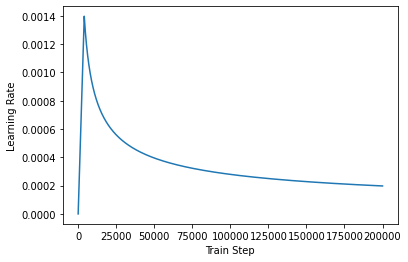

In [34]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [35]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("Ïäù=3")

Ïäù=3


In [36]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
689/689 [==============================] - 83s 107ms/step - loss: 2.1153 - accuracy: 0.0425
Epoch 2/10
689/689 [==============================] - 74s 107ms/step - loss: 1.4982 - accuracy: 0.0791
Epoch 3/10
689/689 [==============================] - 74s 107ms/step - loss: 1.3922 - accuracy: 0.0860
Epoch 4/10
689/689 [==============================] - 63s 91ms/step - loss: 1.3332 - accuracy: 0.0906
Epoch 5/10
689/689 [==============================] - 38s 55ms/step - loss: 1.2822 - accuracy: 0.0947
Epoch 6/10
689/689 [==============================] - 38s 55ms/step - loss: 1.2354 - accuracy: 0.0981
Epoch 7/10
689/689 [==============================] - 38s 55ms/step - loss: 1.1816 - accuracy: 0.1021
Epoch 8/10
689/689 [==============================] - 38s 55ms/step - loss: 1.1191 - accuracy: 0.1075
Epoch 9/10
689/689 [==============================] - 38s 55ms/step - loss: 1.0616 - accuracy: 0.1131
Epoch 10/10
689/689 [==============================] - 38s 55ms/step - loss: 1.

In [41]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # ÏûÖÎ†•Îêú Î¨∏Ïû•ÏùÑ Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑ, ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ ÏïûÎí§Î°ú Ï∂îÍ∞Ä.
    # ex) Where have you been? ‚Üí [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # ÎîîÏΩîÎçîÏùò ÌòÑÏû¨ÍπåÏßÄÏùò ÏòàÏ∏°Ìïú Ï∂úÎ†• ÏãúÌÄÄÏä§Í∞Ä ÏßÄÏÜçÏ†ÅÏúºÎ°ú Ï†ÄÏû•ÎêòÎäî Î≥ÄÏàò.
    # Ï≤òÏùåÏóêÎäî ÏòàÏ∏°Ìïú ÎÇ¥Ïö©Ïù¥ ÏóÜÏùåÏúºÎ°ú ÏãúÏûë ÌÜ†ÌÅ∞Îßå Î≥ÑÎèÑ Ï†ÄÏû•. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # ÎîîÏΩîÎçîÏùò Ïù∏ÌçºÎü∞Ïä§ Îã®Í≥Ñ
    for i in range(MAX_LENGTH):
        # ÎîîÏΩîÎçîÎäî ÏµúÎåÄ MAX_LENGTHÏùò Í∏∏Ïù¥ÎßåÌÅº Îã§Ïùå Îã®Ïñ¥ ÏòàÏ∏°ÏùÑ Î∞òÎ≥µÌï©ÎãàÎã§.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # ÌòÑÏû¨ ÏòàÏ∏°Ìïú Îã®Ïñ¥Ïùò Ï†ïÏàò
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # ÎßåÏïΩ ÌòÑÏû¨ ÏòàÏ∏°Ìïú Îã®Ïñ¥Í∞Ä Ï¢ÖÎ£å ÌÜ†ÌÅ∞Ïù¥ÎùºÎ©¥ forÎ¨∏ÏùÑ Ï¢ÖÎ£å
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # ÏòàÏ∏°Ìïú Îã®Ïñ¥Îì§ÏùÄ ÏßÄÏÜçÏ†ÅÏúºÎ°ú output_sequenceÏóê Ï∂îÍ∞ÄÎê©ÎãàÎã§.
    # Ïù¥ output_sequenceÎäî Îã§Ïãú ÎîîÏΩîÎçîÏùò ÏûÖÎ†•Ïù¥ Îê©ÎãàÎã§.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

print("Ïäù=3")

Ïäù=3


In [42]:
def sentence_generation(sentence):
    # ÏûÖÎ†• Î¨∏Ïû•Ïóê ÎåÄÌï¥ÏÑú ÎîîÏΩîÎçîÎ•º ÎèôÏûë ÏãúÏºú ÏòàÏ∏°Îêú Ï†ïÏàò ÏãúÌÄÄÏä§Î•º Î¶¨ÌÑ¥Î∞õÏäµÎãàÎã§.
    prediction = decoder_inference(sentence)

    # Ï†ïÏàò ÏãúÌÄÄÏä§Î•º Îã§Ïãú ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§Î°ú Î≥ÄÌôòÌï©ÎãàÎã§.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('ÏûÖÎ†• : {}'.format(sentence))
    print('Ï∂úÎ†• : {}'.format(predicted_sentence))

    return predicted_sentence
print("Ïäù=3")

Ïäù=3


In [43]:
sentence_generation('Where have you been?')

ÏûÖÎ†• : Where have you been?
Ï∂úÎ†• : i 


'i '

In [44]:
sentence_generation("It's a trap")

ÏûÖÎ†• : It's a trap
Ï∂úÎ†• : i 


'i '

Ï∞∏Í≥†ÏÇ¨Ìï≠: ÏÇ¨Ïã§ÏÉÅ Í∞ôÏùÄ ÏÇ¨Ïù¥Ìä∏ÏûÑ <br>
https://wikidocs.net/46496 <br>
https://wikidocs.net/31379 <br>
https://velog.io/@w00sah0101/EXPLORATION-12.-%ED%8A%B8%EB%9E%9C%EC%8A%A4%ED%8F%AC%EB%A8%B8%EB%A1%9C-%EB%A7%8C%EB%93%9C%EB%8A%94-%EB%8C%80%ED%99%94%ED%98%95-%EC%B1%97%EB%B4%87 <br>